In [88]:
import numpy as np
import matplotlib.pyplot as plt

from alpub_autoencoder.autoencoder_utils import read_alpub_data
from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
ALPUB_PATH = '../Datasets/alpub_v2/images'

In [71]:
X,Y = read_alpub_data(path=ALPUB_PATH)

Processing Alpha
Processing Beta
Processing Chi
Processing Delta
Processing Epsilon
Processing Eta
Processing Gamma
Processing Iota
Processing Kappa
Processing Lambda
Processing LunateSigma
Processing Mu
Processing Nu
Processing Omega
Processing Omicron
Processing Phi
Processing Pi
Processing Psi
Processing Rho
Processing Tau
Processing Theta
Processing Upsilon
Processing Xi
Processing Zeta


In [78]:
Y.shape

(205797, 24)

In [92]:
X.shape

(205797, 70, 70, 3)

In [94]:
# Convert the RGB images to grayscale
X_gray = []
for img in X:
    image_gray = Image.fromarray(img).convert("L")
    X_gray.append(np.array(image_gray))

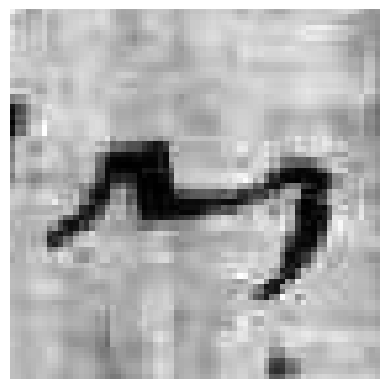

In [100]:
# Display the grayscale image
plt.imshow(X_gray[100000], cmap="gray")
plt.axis("off")
plt.show()

In [107]:
X_in = np.array(X_gray).reshape(len(X_gray), -1)

In [108]:
X_in.shape

(205797, 4900)

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [111]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [ ]:
#you need a test-train split